# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [242]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100

## Torus model

In [19]:
def model(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noisemodel(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = model(z0)  # Using Asimov data

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Inference

In [20]:
sw_list = []

In [21]:
for i_round, nsamples in enumerate([2000, 2000, 2000, 10000]):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = zdim, device = DEVICE, head = head, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = parent, threshold = 1e-4)
    sw_list.append(sw)

    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)

    sw.train1d(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])

Constrained posterior area: 1.0
Adding 1926 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 8
Validation losses: [5.563167095184326, 4.758702099323273, 4.5367558896541595, 4.5350209176540375, 4.527275204658508, 4.441070184111595, 4.34736093878746, 4.395835891366005]
LR iteration 1
Total epochs: 2
Validation losses: [4.109370976686478, 4.125914305448532]
LR iteration 2
Total epochs: 3
Validation losses: [4.1516976952552795, 4.135374948382378, 4.258366599678993]
Constrained posterior area: 0.08876136
Adding 1765 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 4
Validation losses: [6.5513909459114075, 6.1381648778915405, 5.931859225034714, 5.94838759303093]
LR iteration 1
Total epochs: 2
Validation losses: [5.904302358627319, 5.925405263900757]
LR iteration 2
Total epochs: 4
Validation losses: [5.967437326908112, 5.872091680765152, 5.789404064416885, 5.858140796422958]
Constrained posterior area: 0.045491513
Adding 987 new samples. Run simul

In [248]:
print("Total number of samples in datastore:", len(ds))

Total number of samples in datastore: 13610


13610

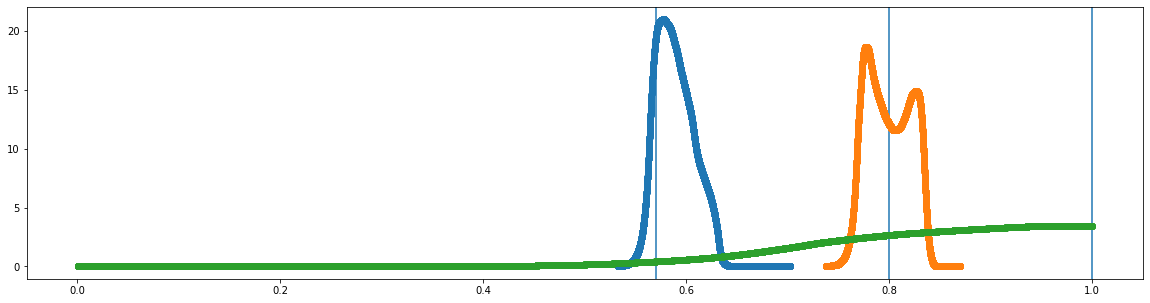

In [23]:
plt.figure(figsize=(20, 5))
for i in range(zdim):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p, marker='o')
#plt.gca().set_yscale('log')
len(ds)

In [24]:
sw_list[-1].trainNd([[0, 1], [1, 2], [0, 2]], max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4], tag = 'b32lA')

Start training
LR iteration 0
Total epochs: 5
Validation losses: [5.1825975477695465, 4.898136496543884, 4.588096112012863, 4.485553175210953, 4.754433065652847]
LR iteration 1
Total epochs: 4
Validation losses: [4.6724110543727875, 4.540301114320755, 4.4123634696006775, 4.499383553862572]
LR iteration 2
Total epochs: 5
Validation losses: [4.5532869547605515, 4.3850164115428925, 4.323502138257027, 4.283305794000626, 4.448469787836075]


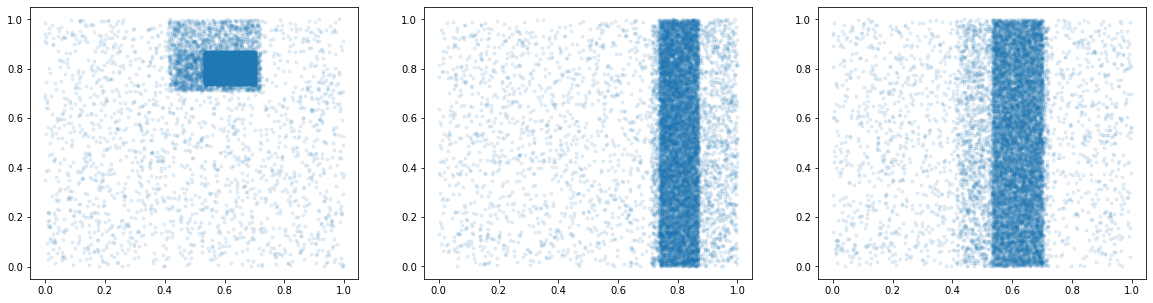

In [127]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.scatter(z[:,0], z[:,1], marker='.', alpha = 0.1)
plt.subplot(132)
plt.scatter(z[:,1], z[:,2], marker='.', alpha = 0.1)
plt.subplot(133)
plt.scatter(z[:,0], z[:,2], marker='.', alpha = 0.1)

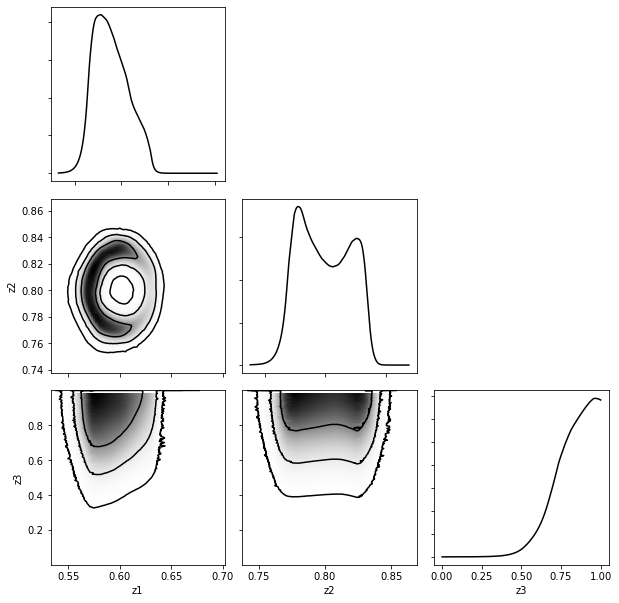

In [247]:
swyft.corner(sw_list[-1], tag = 'b32lA')